In [ ]:
pip install transformers

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
pd.set_option('display.max_colwidth', None)
import nltk
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (plot_roc_curve, plot_precision_recall_curve, 
                             classification_report, plot_confusion_matrix, 
                             roc_curve, roc_auc_score, recall_score, precision_recall_curve)

from transformers import pipeline

import pickle

from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

## read csv

In [ ]:
df = pd.read_csv('pos_and_neg_tweets_balanced_final.csv')

In [ ]:
df.sample(5)

,Unnamed: 0,Unnamed: 0.1,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,category,user_location_updated,user-country_code,user-country
35063,35063,35063,Marta12809119,NaN,NaN,2018-06-07 13:09:14,38,2021-01-21 20:38:06,"RT @vbaileyactor: No, not antivaxx. All my kids were vaccinated. Asking questions about a brand new vaccination with a few areas of potenti…",0,95,True,Negative,NaN,NaN,NaN
17686,17686,17686,robbiederby,NaN,NaN,2009-07-09 08:41:59,60,2021-02-05 18:09:26,"#antivaxxers and #antimaskers, #SocialDistancing themselves from reality.\n\n#COVID19 #coronavirus #StaySafe #StayHome",0,0,False,Negative,NaN,NaN,NaN
387,387,387,GoAHealth,"Alberta, Canada",For help with government services call 310-0000 or send us a direct message.,2011-06-09 21:53:50,22707,2021-02-11 19:25:55,RT @AHS_media: Ninety-eight-year-old Dorothy Boothman is pictured receiving the COVID-19 vaccine from Registered nurse Brenda Claudio in #Y…,0,2,True,Positive,"Alberta, Canada",CAN,Canada
34004,34004,34004,GBilleci9,Earth,i: a man; am happy to be here; conscious over compulsive is the key; sui juris.,2018-01-07 23:29:44,98,2021-01-21 15:19:47,RT @NickHudsonCT: Raising conflicts of interest DOES NOT make you a conspiracy theorist.\n\nQuerying safety &amp; efficacy DOES NOT make you anti…,0,1758,True,Negative,Earth,NaN,NaN
33688,33688,33688,AngieWebcam,NaN,18+ #CamModel \nCheck my pinned tweet to find the sites where i'm live & where i sell my vids 😘,2013-01-24 21:11:20,108481,2021-01-21 20:56:47,RT @NickHudsonCT: Raising conflicts of interest DOES NOT make you a conspiracy theorist.\n\nQuerying safety &amp; efficacy DOES NOT make you anti…,0,1758,True,Negative,NaN,NaN,NaN


In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'user_name', 'user_location',
       'user_description', 'user_created', 'user_followers', 'date', 'text',
       'favorites', 'retweets', 'is_retweet', 'category',
       'user_location_updated', 'user-country_code', 'user-country'],
      dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(19039, 14)

In [ ]:
df['category'].value_counts(normalize=True)

Positive    0.647093
Negative    0.352907
Name: category, dtype: float64

### date column

In [ ]:
df['date'] = df['date'].apply(lambda x: x.split('+')[0])

In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [ ]:
print(f"Wehave data from {df.date.min()} up to {df.date.max()}")

Wehave data from 2021-01-15 03:10:18 up to 2021-02-18 14:20:06


In [ ]:
df['week_day'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['hour'] = df['date'].dt.hour
df.sample()

,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,category,user_location_updated,user-country_code,user-country,week_day,month,year,hour
5082,MASizMore,"Dallas, TX","Just a tall 🔯 guy from L.A. living in Dallas, via Israel, NYC, & Boston. Mets⚾️ Patriots🏈 Lakers🏀. Sports fan, music lover, & tech geek. #1 on 2010 #JTA100",2014-10-21 19:01:39,5192,2021-02-03 00:21:59,I was fortunate enough to get the COVID-19 vaccine today. Second dose in 3 weeks. Thank you @utswnews and… https://t.co/sra16otBoi,2,0,False,Positive,"Dallas, TX",USA,United States,2,2,2021,0


distribution of tweets by time:

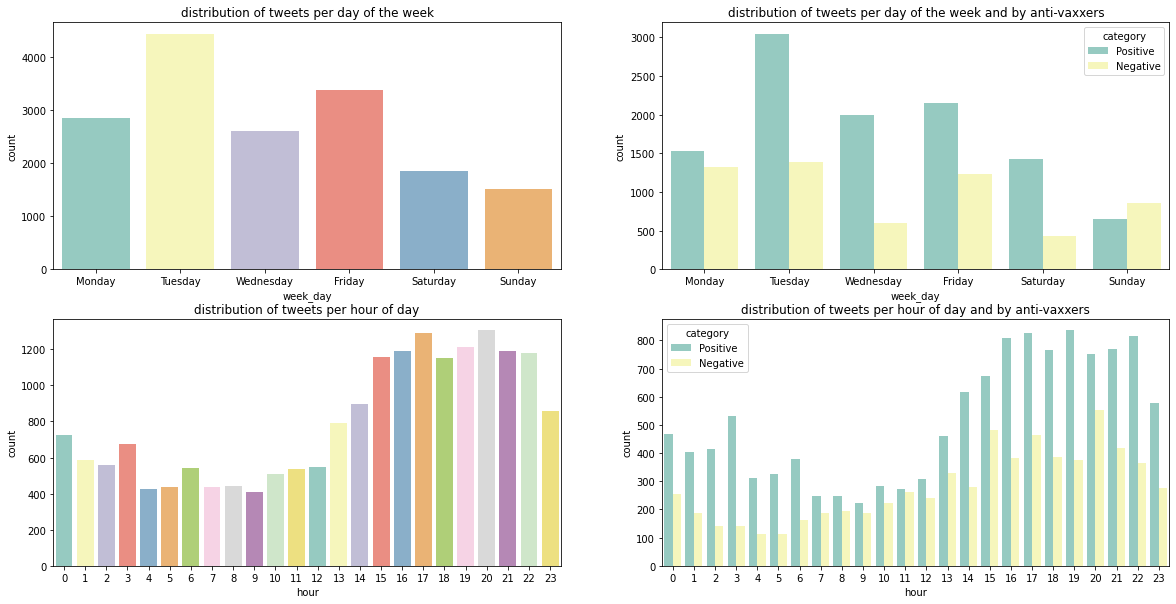

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
day_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
sns.countplot(df["week_day"].map(day_of_week), 
              order=['Monday', 'Tuesday', 'Wednesday', 'Friday', 'Saturday', 'Sunday'],
              palette="Set3", ax=ax[0,0])
ax[0,0].set_title("distribution of tweets per day of the week")
sns.countplot(df["week_day"].map(day_of_week), 
              order=['Monday', 'Tuesday', 'Wednesday', 'Friday', 'Saturday', 'Sunday'],
              palette="Set3", hue=df["category"], ax=ax[0,1])
ax[0,1].set_title("distribution of tweets per day of the week and by anti-vaxxers")
sns.countplot(df["hour"], order= df["hour"].unique().sort(), ax=ax[1,0], palette="Set3",)
ax[1,0].set_title("distribution of tweets per hour of day")
sns.countplot(df["hour"], order= df["hour"].unique().sort(), ax=ax[1,1], hue=df["category"], palette="Set3")
ax[1,1].set_title("distribution of tweets per hour of day and by anti-vaxxers");

As we already saw - there are more non-anti-vaccination ("positive") tweets compared to anti-vaccination ("negative") tweets, but we can see that their distribution, both acros day of the week and hour of the day, are the same. \
hence we can conclude that the type of tweets is not linearly correlated to the tweet that the tweet was published.


**NOTE**: we do see some small changes based on day of the week, where for, we will keep that column.

In [ ]:
df.drop("hour", axis=1, inplace=True)

### looking on the number of speacial signes in a text:

In [ ]:
# df['text'].str.count('\?|\!').value_counts()

In [ ]:
df["tweet_?!_marks"] = df['text'].str.count('\?|\!')
df.sample(2)

,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,category,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks
33898,reggieesustaita,hopeworld,feelin like a walking love song | ♡ | she/her,2015-01-19 03:51:54,430,2021-01-21 17:06:44,"RT @imanihaskell: I’m not antivaxx by any means, but I’m anti THIS vaccine, right now at lest. I’ll be fine waiting a few months before I f…",0,2,True,Negative,hopeworld,NaN,NaN,3,1,2021,0
4856,AK9dj,NaN,💯 female. She/her.\nAll the tweets/rt are my own preference and opinion.\nMy tweet/rt contents are sharing information & not intended to against to any party.,2020-09-07 22:59:17,273,2021-02-07 11:43:39,"RT @DeptofDefense: #IGotTheShot: @USArmy Gen. Christopher Cavoli, commanding general of @USArmyEURAF, explains why he decided to get the #C…",0,95,True,Positive,NaN,NaN,NaN,6,2,2021,0


In [ ]:
df[~df['user-country_code'].isna()].shape # many missing values, hence we will change it to "Other" or "OTH"

(7876, 18)

In [ ]:
# "OTH" in df['user-country_code'].unique() # --> False

In [ ]:
df["user-country"] = df["user-country"].fillna("Other")
df['user-country_code'] = df['user-country_code'].fillna("OTH")
df.sample(5)

,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,category,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks
180,ukedalum,Kentucky,Math Recovery Specialist/U K alum x2|Spalding alum|Educator,2010-09-30 02:17:47,90,2021-02-14 19:41:54,@acrphoto Welcome to the club!! #shotofhope,0,0,False,Positive,Kentucky,USA,United States,6,2,2021,2
28940,ThisIsOurShot,United States,To elevate voices of healthcare heroes to build vaccine-trust towards a covid-free world. #ThisIsOurShot,2020-12-24 20:41:17,594,2021-01-16 01:22:10,RT @amykpatel: Dose #2 of the @pfizer vaccine is complete! #GetVaccinated #IGotTheShot #ThisIsOurShot #COVID19 #InThisTogether https://t.co…,0,3,True,Positive,United States,OTH,Other,5,1,2021,1
5414,tomdobbie,"Langholm, Scotland",Cameraman/DoP https://t.co/RqBbh1a5Kh You can also find me on Instagram https://t.co/o7sYK3JNuV,2009-05-19 21:15:27,814,2021-02-09 11:10:18,RT @indyNurseBrian: Had to continue on foot a couple of times today but not a drop wasted and 22 home visits plus 37 residents and 11 staff…,0,227,True,Positive,"Langholm, Scotland",GBR,United Kingdom,1,2,2021,0
30828,cceyers,Detroit,"Mom, Dog Mom, Wife, Director, Athletic Trainer, Advocate, Crafter, Insomniac & Human Being",2013-04-06 13:50:32,151,2021-01-17 23:09:38,Took this beauty earlier today to get her first dose of the Pfizer vaccine. She is a nurse assistant at HF Main Hos… https://t.co/piGIfcgFhg,8,0,False,Positive,Detroit,OTH,Other,6,1,2021,0
8848,MurfActual1,Calm amidst the mayhem,Serial deal maker. ΜΟΛΩΝ ΛΑΒΕ. Consigliere. Keen observer. Leader; Follower. Teacher ; Student. Speaker ; Listener. Connoisseur of sharp objects,2013-04-04 15:09:38,4623,2021-02-16 17:34:49,RT @RebelRancher: No seed oils (PLANTS). No COVID. \n\nThe hoax is that you’re already all knocking on death’s door internally because of you…,0,12,True,Negative,Calm amidst the mayhem,OTH,Other,1,2,2021,0


now, we will create a dictionary with the countries as values and the country codes as keys:

In [ ]:
country_dict = pd.Series(df['user-country'].values,index=df['user-country_code']).to_dict()

create a dataframe that avoids "OTH" and grouped by countries

In [68]:
df_country_draft = df.copy()
category_dict = {"Positive":0, "Negative":1}
df_country_draft['category'] = df_country_draft['category'].map(category_dict)
df_country = df_country_draft.groupby(["user-country", 'user-country_code'])['category'].mean().reset_index()
df_country.rename(columns={"category": "Anti-Vaccination Tweets %"}, inplace=True)

df_country.sample(3)

,user-country,user-country_code,Anti-Vaccination Tweets %
21,Congo Republic,COG,0.0
82,Peru,PER,0.0
31,El Salvador,SLV,0.0


In [69]:
fig = px.choropleth(data_frame=df_country, color="Anti-Vaccination Tweets %", hover_name='user-country',
                    locations="user-country_code", projection="natural earth")
fig.update_geos(showcoastlines=True, coastlinecolor="Black",
                showland=True, landcolor="LightGrey",
                showocean=True, oceancolor="LightBlue",
                showlakes=True, lakecolor="LightBlue",
                showrivers=True, rivercolor="LightBlue",
                showcountries=True, countrycolor="Black")
fig.update_layout(title="Anti-Vax tweets precentages", geo_scope="world")

fig.show()

### cleaning content column

In [72]:
df["up_text"] = df.text.str.lower()
#Remove twitter handlers
df.up_text = df.up_text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df.up_text = df.up_text.apply(lambda x:re.sub(r'\B#\S+','',x))

# Remove URLS
df.up_text = df.up_text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
df.up_text = df.up_text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


In [73]:
df['hashtags'] =  df.text.str.lower()
df.hashtags = df.hashtags.apply(lambda x:re.sub('@[^\s]+','',x)) 
df.hashtags = df.hashtags.apply(lambda x:re.sub(r"http\S+", "", x))
df.hashtags = df.hashtags.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
df.hashtags = df.hashtags.apply(lambda x: x if '#' in x else '')
df.hashtags = df.hashtags.apply(lambda x: [i for i in x.split() if i.startswith('#')])

### expand contractions


In [74]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not ","'s":" is ","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['up_text']=df['up_text'].apply(lambda x:expand_contractions(x))

In [75]:
for index,text in enumerate(df['up_text'][35:40]):
    print('tweet %d:\n'%(index+1),text)

tweet 1:
 rt thank you and all volunteers working the vaccine clinic this team has provided over 70 of our employees a
tweet 2:
 rt looking at how hard these scientists have probably worked to get this vaccine made in suchshort amount of time says icu
tweet 3:
 rt thank you and all volunteers working the vaccine clinic this team has provided over 70 of our employees a
tweet 4:
 thank you and all volunteers working the vaccine clinic this team has provided over 70 of our em
tweet 5:
 rt kentuckycovid 19 vaccine program to getsupply boost of more than 20 next week


create tokenized column with no stop words 

In [76]:
df['tokenized'] = df['up_text'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)


In [77]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['tokenized'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [78]:
wnl = WordNetLemmatizer()
df['tokenized'] = df['tokenized'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [79]:
# df.tokenized[:5]

In [80]:
df['user_created'] = pd.to_datetime(df['user_created'], infer_datetime_format=True).dt.date
df['n_words'] = df['up_text'].apply(lambda x: len(x.split()))

### splitting:

In [81]:
np.random.seed(42)
target = 'category'
features1 = list([col for col in df.columns if col != target])

X, y = df[features1], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15231, 22), (3808, 22), (15231,), (3808,))

### taking care of user_name

In [82]:
df.user_name.value_counts()[:15] 

Nakhasi_MD         387
SunshineTheGrey    130
drkkyu              81
ThisIsOurShot       75
Cagsil              75
NYCHealthSystem     67
doritmi             58
lizditz             55
KimYuMD             51
DeniseVFriend       45
JZtoRlIkqoYOEDl     44
viralvideovlogs     36
DrIanWeissman       32
lostcreatives1      30
MeIAmBen1           28
Name: user_name, dtype: int64

In [83]:
ten_most_common_names = X_train.user_name.value_counts().keys().tolist()[:10]
X_train['ten most common names'] = X_train.apply (lambda row: 1 if row.user_name in ten_most_common_names else 0 , axis=1)
X_test['ten most common names'] = X_test.apply (lambda row: 1 if row.user_name in ten_most_common_names else 0 , axis=1)
display(X_train.sample(3))
display(X_test.sample(3))

,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names
36,CMOH_Alberta,Alberta,"Alberta’s Chief Medical Officer of Health. Account run by staff, providing public health updates on COVID-19. Essential info: https://t.co/Hq1t7pOpwT",2020-03-16,126472,2021-02-17 20:54:13,"RT @AHS_media: “Looking at how hard these scientists have probably worked to get this vaccine made in such a short amount of time,”says ICU…",0,12,True,Alberta,CAN,Canada,2,2,2021,0,rt looking at how hard these scientists have probably worked to get this vaccine made in suchshort amount of time says icu,[],"[rt, look, hard, scientist, probably, work, get, vaccine, make, suchshort, amount, time, say, icu]","[(rt, NN), (looking, VBG), (hard, JJ), (scientists, NNS), (probably, RB), (worked, VBD), (get, VB), (vaccine, NN), (made, VBN), (suchshort, NN), (amount, NN), (time, NN), (says, VBZ), (icu, NN)]",22,0
5940,PemaYongchen,"The Boston Mountains, the oldest mountains on the planet",Earth Sculptor & Native Plant Grower\nPreserving the Past for Tomorrow Today\nIt's Time for a New Paradigm \nI'd rather self-isolate than ventilate. \nStay home.,2018-03-19,6790,2021-02-08 22:57:02,RT @emiliainnyc: Citi Field vaccination hub to open Wednesday 💉 #covid19 #GetVaccinated \n\nhttps://t.co/4oHtGYAeZd,0,2,True,"The Boston Mountains, the oldest mountains on the planet",OTH,Other,0,2,2021,0,rt citi field vaccination hub to open wednesday,"[#covid19, #getvaccinated]","[rt, citi, field, vaccination, hub, open, wednesday]","[(rt, NN), (citi, JJ), (field, NN), (vaccination, NN), (hub, NN), (open, JJ), (wednesday, NN)]",8,0
28855,JanieceStaton,"Beaverton, Oregon, USA","Hello! Devoted & disabled RN, BSN, MSW, MAT, who has redefined my career as Activist & Advocate. RTs don't = endorsements! Shalom!",2011-11-11,2671,2021-01-17 06:32:27,"RT @WADeptHealth: 200,000 vaccinations &amp; counting for Washington’s healthcare workers! Thank you for working tirelessly to keep our state s…",0,44,True,"Beaverton, Oregon, USA",OTH,Other,6,1,2021,1,rt 200 000 vaccinations amp counting for washingtonhealthcare workers thank you for working tirelessly to keep our state s,[],"[rt, 200, 000, vaccination, amp, count, washingtonhealthcare, worker, thank, work, tirelessly, keep, state]","[(rt, NN), (200, CD), (000, CD), (vaccinations, NNS), (amp, VBP), (counting, VBG), (washingtonhealthcare, NN), (workers, NNS), (thank, VBD), (working, VBG), (tirelessly, RB), (keep, VB), (state, NN)]",19,0


,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names
28421,NACHC,"Bethesda, MD",The leading advocacy organization in support of Community Health Centers and the expansion of health care access for the uninsured and medically underserved.,2008-12-30,10587,2021-01-21 23:55:54,"RT @NorthPointMpls: “I got my vaccine to protect my son who is not old enough to get his shot!” - Erin, NorthPoint Lab Tech\n\n#igottheshot #…",0,1,True,"Bethesda, MD",OTH,Other,3,1,2021,1,rtgot my vaccine to protect my son who is not old enough to get his shot erin northpoint lab tech,"[#igottheshot, #…]","[rtgot, vaccine, protect, son, old, enough, get, shot, erin, northpoint, lab, tech]","[(rtgot, NN), (vaccine, NN), (protect, VBP), (son, NN), (old, JJ), (enough, RB), (get, VBP), (shot, JJ), (erin, NN), (northpoint, NN), (lab, NN), (tech, NN)]",20,0
33449,ITjodie,Commiefornia RV refugee,prlr: @cryptomojo gab: @cryptocoinjo-Red Pilled. Freedom loving agorist. Truth is not negotiable. Seek to understand. Be the change. Think~Act~Believe.,2008-11-30,141,2021-01-22 05:37:26,RT @NickHudsonCT: Raising conflicts of interest DOES NOT make you a conspiracy theorist.\n\nQuerying safety &amp; efficacy DOES NOT make you anti…,0,1758,True,Commiefornia RV refugee,OTH,Other,4,1,2021,0,rt raising conflicts of interest does not make youconspiracy theorist querying safety amp efficacy does not make you anti,[],"[rt, raise, conflict, interest, make, youconspiracy, theorist, query, safety, amp, efficacy, make, anti]","[(rt, NN), (raising, VBG), (conflicts, NNS), (interest, NN), (make, VBP), (youconspiracy, NN), (theorist, NN), (querying, VBG), (safety, NN), (amp, NN), (efficacy, NN), (make, VBP), (anti, NN)]",19,0
28883,CMEdPrince,"Renton, WA","Councilmember, City of Renton\n\nPresident, Sound Cities Association\n\nBoardmember, Sound Transit\n\nVice Chair, GMPB\n\nRT's & Likes ≠ endorsement",2017-12-07,140,2021-01-16 21:33:55,"RT @WADeptHealth: 200,000 vaccinations &amp; counting for Washington’s healthcare workers! Thank you for working tirelessly to keep our state s…",0,44,True,"Renton, WA",OTH,Other,5,1,2021,1,rt 200 000 vaccinations amp counting for washingtonhealthcare workers thank you for working tirelessly to keep our state s,[],"[rt, 200, 000, vaccination, amp, count, washingtonhealthcare, worker, thank, work, tirelessly, keep, state]","[(rt, NN), (200, CD), (000, CD), (vaccinations, NNS), (amp, VBP), (counting, VBG), (washingtonhealthcare, NN), (workers, NNS), (thank, VBD), (working, VBG), (tirelessly, RB), (keep, VB), (state, NN)]",19,0


### taking care of text content:

In [84]:
words = X_train['tokenized']
allwords = []
for wordlist in words:
    allwords += wordlist
allwords = [word for word in allwords if word !='amp']
allwords = [word for word in allwords if word !='rt']

In [85]:
mostcommon = FreqDist(allwords).most_common(100)
mostcommon = [tup[0] for tup in mostcommon]
# mostcommon[:5]

In [86]:
def most_common_token(token):
    new_token=[]
    for word in token:
        if word in mostcommon:
            new_token.append(word)
    return new_token

In [87]:
X_train['tokenized_common'] = X_train['tokenized'].apply(lambda x: most_common_token(x))

In [88]:
X_test['tokenized_common'] = X_test['tokenized'].apply(lambda x: most_common_token(x))

In [89]:
display(X_train.sample(3))
display(X_test.sample(3))

,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names,tokenized_common
7285,Shanzayy10,NaN,Who are you to judge me?,2020-09-25,32,2021-02-09 06:20:45,RT @PakFightsPolio: Share information &amp; encourage vaccination because #VaccinesWork to 👇\n\n✅ Save lives\n✅ Help children grow healthy\n✅ Preve…,0,11,True,NaN,OTH,Other,1,2,2021,0,rt share information amp encourage vaccination because to save lives help children grow healthy preve,[#vaccineswork],"[rt, share, information, amp, encourage, vaccination, save, life, help, child, grow, healthy, preve]","[(rt, NN), (share, NN), (information, NN), (amp, NN), (encourage, NN), (vaccination, NN), (save, VBP), (lives, NNS), (help, VBP), (children, NNS), (grow, VB), (healthy, JJ), (preve, NN)]",15,0,"[share, vaccination, life, help]"
14004,csibike1,"London as yet UK, Europe","migrant, ex civil servant, vegetarian, owned by 2 dogs. Saddened by extremism, cruelty, injustice & hates fascism #LongLiveEurope #BlackLivesMatter",2009-08-28,8985,2021-02-05 14:08:33,"@ArielWelby @AllanGPaterson All paid for by Soros, and in reality I am very ill as I stand between them and world d… https://t.co/fCSGHf6Jd2",2,0,False,"London as yet UK, Europe",OTH,Other,4,2,2021,0,all paid for by soros and in realityam very ill asstand between them and world d,[],"[pay, soros, realityam, ill, asstand, world]","[(paid, VBN), (soros, NNS), (realityam, VBP), (ill, JJ), (asstand, NN), (world, NN)]",16,0,[]
7947,SloughPH,"Slough, South East",The Slough Borough Council Public Health team. Bringing you local news and opportunities. Helping improve the health and wellbeing of Slough residents.,2017-06-21,1485,2021-02-08 17:29:59,Are you over 70? Then you can now book your COVID vaccine directly without waiting for your GP notification.\n \nYou… https://t.co/gppYJTppwQ,9,8,True,"Slough, South East",GBR,United Kingdom,0,2,2021,1,are you over 70 then you can now book your covid vaccine directly without waiting for your gp notification you,[],"[70, book, covid, vaccine, directly, without, wait, gp, notification]","[(70, CD), (book, NN), (covid, NN), (vaccine, NN), (directly, RB), (without, IN), (waiting, VBG), (gp, NN), (notification, NN)]",20,0,"[covid, vaccine]"


,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names,tokenized_common
2073,BenRodriguez413,"Suffield, Connecticut","CT family man from Western, MA. Love my country and sticking up for what’s right. Puerto Rican (viva Humacao), politics, news, sports. Opinions are mine alone.",2011-01-09,519,2021-02-17 02:34:16,RT @ValerieJHorsley: I guess I need to say it again. Vaccines do NOT cause autism. Definitive. No question. #VaccinesWork #ctpolitics #publ…,0,7,True,"Suffield, Connecticut",USA,United States,2,2,2021,0,rtguessneed to say it again vaccines do not cause autism definitive no question,"[#vaccineswork, #ctpolitics, #publ…]","[rtguessneed, say, vaccine, cause, autism, definitive, question]","[(rtguessneed, NNS), (say, VBP), (vaccines, NNS), (cause, VBP), (autism, NN), (definitive, JJ), (question, NN)]",13,0,"[say, vaccine, question]"
29589,NY_Tuck,"Costa Mesa, CA","Chief of Plastic Surgery, SCPMG OC. 🖥 Regional HealthConnect Lead. Husband, Father, Lover of Blues, BBQ, Golf tweets&opinions=mine #PermanenteProud #Grateful🌞",2009-07-22,317,2021-01-22 21:23:37,"RT @CareByFirefly: We're so grateful that the @moderna_tx #CovidVaccine is available to our clinicians, &amp; soon the rest of #Massachusetts!…",0,7,True,"Costa Mesa, CA",OTH,Other,4,1,2021,1,rt we re so grateful that the is available to our clinicians amp soon the rest of,"[#covidvaccine, #massachusetts!…]","[rt, grateful, available, clinician, amp, soon, rest]","[(rt, NN), (grateful, NN), (available, JJ), (clinicians, NNS), (amp, VBP), (soon, RB), (rest, NN)]",17,0,[]
32798,G55Pam,Yeadon,NaN,2014-01-04,141,2021-01-19 18:22:16,RT @WayneMo18011749: @DavidDavisMP @HouseofCommons How about our civil liberties?\n\nWhere is the Government's Lockdown Economic Impact Asses…,0,17,True,Yeadon,OTH,Other,1,1,2021,1,rt how about our civil liberties where is the governmentlockdown economic impact asses,[],"[rt, civil, liberty, governmentlockdown, economic, impact, ass]","[(rt, NN), (civil, JJ), (liberties, NNS), (governmentlockdown, VBP), (economic, JJ), (impact, NN), (asses, NNS)]",13,0,[impact]


In [90]:
empty_tokens_train = X_train[(X_train['tokenized_common'].str.len() == 0)].index
print('train before: {}'.format(X_train.shape))
df1 = X_train.drop(empty_tokens_train)
print('train after: {}'.format(X_train.shape))

train before: (15231, 24)
train after: (15231, 24)


In [91]:
empty_tokens_test = X_test[(X_test['tokenized_common'].str.len() == 0)].index
print('test before: {}'.format(X_test.shape))
df1 = X_test.drop(empty_tokens_test)
print('test after: {}'.format(X_test.shape))

test before: (3808, 24)
test after: (3808, 24)


In [92]:
for word in mostcommon:
    X_train[word]=0
    X_test[word]=0
X_train = X_train.reset_index()
X_test = X_test.reset_index()
for index, row in tqdm(enumerate(X_train.tokenized_common)):
    for word in row:
        X_train.loc[index, word] = 1
for index, row in tqdm(enumerate(X_test.tokenized_common)):
    for word in row:
        X_test.loc[index, word] = 1       

In [93]:
# checking to see if all are the same columns, although we used X_train most common words 
assert X_test.shape[1] == X_train.shape[1]
set(X_train.columns) - set(X_test.columns)

set()

In [94]:
y_test.unique(), y_train.unique()

(array(['Negative', 'Positive'], dtype=object),
 array(['Positive', 'Negative'], dtype=object))

In [95]:
y_test.isna().sum(), y_train.isna().sum()

(0, 0)

### Changing the target values to numeric binary values

In [96]:
category_dict = {"Positive":0, "Negative":1}
y_train = y_train.map(category_dict)
y_test = y_test.map(category_dict)

### sentimental analysis:

In [97]:
sentiment_analysis = pipeline('sentiment-analysis')

In [98]:
# this cell takes time to run... ~20 min

transformer_sentiments_train = X_train.up_text.apply(sentiment_analysis)
transformer_sentiments_test = X_test.up_text.apply(sentiment_analysis)

In [99]:
labels_train, labels_test = [], []
scores_train, scores_test = [], []

for sentiment in transformer_sentiments_train:
    labels_train.append(sentiment[0]['label'])
    scores_train.append(round(sentiment[0]['score'], 4))
    
for sentiment in transformer_sentiments_test:
    labels_test.append(sentiment[0]['label'])
    scores_test.append(round(sentiment[0]['score'], 4))

In [100]:
X_train['sentiment'] = labels_train
X_train['score'] = scores_train

X_test['sentiment'] = labels_test
X_test['score'] = scores_test

display(X_train[['text', 'sentiment', 'score']].sample(5))
display(X_test[['text', 'sentiment', 'score']].sample(5))

,text,sentiment,score
1504,RT @ACCESSHealth: This week's #FridayFeeling is dedicated to our hardworking ACCESS staff who have all been recently vaccinated against #CO…,POSITIVE,0.9880
12657,RT @jeni_ward: Thank you @GovAndyBeshear @StevenStackMD and #UKHealthCare. Definitely a shot of hope ❤️ #ShotOfHope #TeamKentucky #StopTheS…,POSITIVE,0.9998
10456,One step closer to normal! 💙 I can’t wait to be back in my classroom with my kids. Thank you @GovAndyBeshear for al… https://t.co/LqBNiFsYWf,POSITIVE,0.9993
6880,RT @SchNursesBstoke: Our amazing Kate on sky news helping the COViD -19 vaccination programs well done #GetVaccinated #COVIDVaccination htt…,POSITIVE,0.9986
974,RT @NickHudsonCT: Raising conflicts of interest DOES NOT make you a conspiracy theorist.\n\nQuerying safety &amp; efficacy DOES NOT make you anti…,NEGATIVE,0.9989


,text,sentiment,score
2247,@Bozaster @naomirwolf @JenniferSey @momsforliberty Or explain THIS away...\n#COVIDHOAX #COVID1984 #PLANDEMIC https://t.co/WMHV58gX6K,NEGATIVE,0.9971
3023,RT @macroliter: Very important &amp; timely 🧵 #VaccinesWork #VaccinesSaveLives,POSITIVE,0.9949
244,"This is me, taking my second covid-19 vaccine #DBZ #DragonBallZ #vaccine #COVID19 #CovidVaccine #Pfizervaccine… https://t.co/lQxWfylg4K",NEGATIVE,0.9953
2045,"RT @1stCavalryDiv: #FirstTeam, defending the country starts with protecting ourselves, and our readiness. #GetTheShot #ShowUsYourShot #Go…",POSITIVE,0.9586
2699,If you're an antivaxer and your kid dies from a cured disease you should be tried for murder. #antivax #idiots,NEGATIVE,0.9990


In [101]:
# just to verify that the test set have the same samples:
np.array_equal(X_test['index'].values, np.array(y_test.index))

True

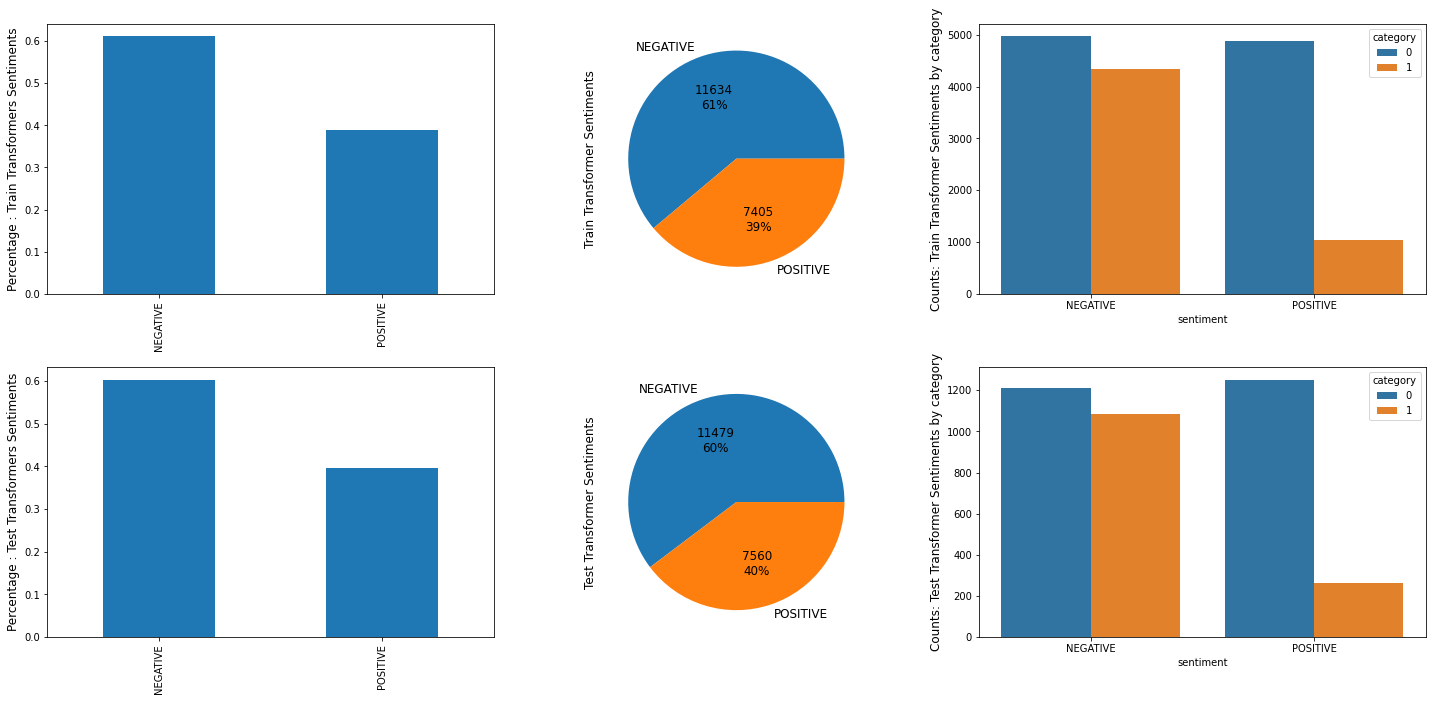

In [102]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

train = X_train.merge(y_train.reset_index(), on='index')
test = X_test.merge(y_test.reset_index(), on='index')

counts_train = train['sentiment'].value_counts()
counts_test = test['sentiment'].value_counts()
percent_train = counts_train/sum(counts_train)
percent_test = counts_test/sum(counts_test)

fig, ax = plt.subplots(2,3, figsize=(20, 10))
percent_train.plot(kind='bar', ax=ax[0,0])
ax[0,0].set_ylabel('Percentage : Train Transformers Sentiments', size=12)
train.groupby('sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12}, ax=ax[0,1])
ax[0,1].set_ylabel('Train Transformer Sentiments', size=12)
ax[0,2] = sns.countplot(x="sentiment", hue="category", data=train, ax=ax[0,2])
ax[0,2].set_ylabel('Counts: Train Transformer Sentiments by category', size=12)
percent_test.plot(kind='bar', ax=ax[1,0])
ax[1,0].set_ylabel('Percentage : Test Transformers Sentiments', size=12)
test.groupby('sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12}, ax=ax[1,1])
ax[1,1].set_ylabel('Test Transformer Sentiments', size=12)
ax[1,2] = sns.countplot(x="sentiment", hue="category", data=test, ax=ax[1,2])
ax[1,2].set_ylabel('Counts: Test Transformer Sentiments by category', size=12)
plt.tight_layout()
plt.show()

By looking at those results, we can understand that in order to determine the possibility of a tweet to have a non-anti-vaccination content, it will probably be affected by the sentiment feature - there is a high chance that non-anti-vaccination tweet will have a positive sentiment.

In [103]:
tf_sentiment_dict = {key.upper():value for key, value in category_dict.items()}
X_train['sentiment'] = X_train['sentiment'].map(tf_sentiment_dict)
X_test['sentiment'] = X_test['sentiment'].map(tf_sentiment_dict)
display(X_train.sample())
display(X_test.sample())

,index,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names,tokenized_common,vaccine,get,covid,make,today,anti,19,antivaxx,vaccinate,time,first,people,vaccination,thank,receive,1,2,dose,week,safety,interest,theorist,conflict,efficacy,raise,one,query,day,youconspiracy,help,home,take,staff,health,see,u,new,prediction,work,shot,continue,say,community,resident,care,need,go,second,2nd,every,give,know,administer,protect,worker,safe,state,good,dr,visit,family,nothing,11,impact,come,million,change,share,part,watch,team,important,much,keep,love,kentucky,across,thanks,waste,37,22,many,plus,roll,question,6,footcouple,notdrop,life,like,street,000,look,itgoing,summer,beturbulent,old,last,vaxxers,sentiment,score
8525,6283,Kathlee72368858,Central Kentucky,Equine Goddess. New England transplant in a Red State. Nurse.,2020-12-23,40,2021-02-07 21:00:01,RT @GovAndyBeshear: We are vaccinating people faster than we get doses from the federal government. If you’re having a hard time signing up…,0,53,True,Central Kentucky,USA,United States,6,2,0,0,rt we are vaccinating people faster than we get doses from the federal government if you re havinghard time signing up,[],"[rt, vaccinate, people, faster, get, dose, federal, government, havinghard, time, signing]","[(rt, NN), (vaccinating, VBG), (people, NNS), (faster, RBR), (get, VBP), (doses, VBZ), (federal, JJ), (government, NN), (havinghard, NN), (time, NN), (signing, NN)]",21,0,"[vaccinate, people, get, dose, time]",0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.9967


,index,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names,tokenized_common,vaccine,get,covid,make,today,anti,19,antivaxx,vaccinate,time,first,people,vaccination,thank,receive,1,2,dose,week,safety,interest,theorist,conflict,efficacy,raise,one,query,day,youconspiracy,help,home,take,staff,health,see,u,new,prediction,work,shot,continue,say,community,resident,care,need,go,second,2nd,every,give,know,administer,protect,worker,safe,state,good,dr,visit,family,nothing,11,impact,come,million,change,share,part,watch,team,important,much,keep,love,kentucky,across,thanks,waste,37,22,many,plus,roll,question,6,footcouple,notdrop,life,like,street,000,look,itgoing,summer,beturbulent,old,last,vaxxers,sentiment,score
633,9212,Glenntwts,UK,"Writer, editor, researcher. PhD supervisor - E pluribus unum . \n\n\n#ComeonyouSaints #46 @SouthamptonFC",2011-03-09,314,2021-02-15 20:58:17,"Unsurprisingly #Panorama not going down well with the #Antivaxxers, #Coviddeniers #COVIDIOT #KBF crew. I don't think it was supposed too.",25,2,True,UK,GBR,United Kingdom,0,2,0,0,unsurprisingly not going down well with the crewdonthink it was supposed too,"[#panorama, #antivaxxers,, #coviddeniers, #covidiot, #kbf]","[unsurprisingly, go, well, crewdonthink, suppose]","[(unsurprisingly, RB), (going, VBG), (well, RB), (crewdonthink, VB), (supposed, VBN)]",12,0,[go],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.9997


Let's take care of location using one-hot-encoding: 

In [104]:
print(f"The number of country values in train that aren't in the test: {len(set(X_train['user-country_code']) - set(X_test['user-country_code']))}")
print(f"The number of countries values that are unique to the test set : {len(set(X_test['user-country_code']) - set(X_train['user-country_code']))}, and they are:\n{set(X_test['user-country_code']) - set(X_train['user-country_code'])}")

The number of country values in train that aren't in the test: 46
The number of countries values that are unique to the test set : 5, and they are:
{'KHM', 'URY', 'SYR', 'KAZ', 'BRB'}


(insted of 'BRB', 'KHM', 'SYR', 'URY', 'KAZ' country code, we will change it to 'OTH' - that will be under our "Other" catagory. \


In [105]:
replace_values_test = list(set(X_test['user-country_code']) - set(X_train['user-country_code']))
X_test.loc[X_test["user-country_code"].isin(replace_values_test), "user-country_code"] = "OTH"
# X_test.isna().sum() # just a verification - all good
X_test.loc[X_test["user-country_code"].isin(replace_values_test)] # just a check

,index,user_name,user_location,user_description,user_created,user_followers,date,text,favorites,retweets,is_retweet,user_location_updated,user-country_code,user-country,week_day,month,year,tweet_?!_marks,up_text,hashtags,tokenized,pos_tags,n_words,ten most common names,tokenized_common,vaccine,get,covid,make,today,anti,19,antivaxx,vaccinate,time,first,people,vaccination,thank,receive,1,2,dose,week,safety,interest,theorist,conflict,efficacy,raise,one,query,day,youconspiracy,help,home,take,staff,health,see,u,new,prediction,work,shot,continue,say,community,resident,care,need,go,second,2nd,every,give,know,administer,protect,worker,safe,state,good,dr,visit,family,nothing,11,impact,come,million,change,share,part,watch,team,important,much,keep,love,kentucky,across,thanks,waste,37,22,many,plus,roll,question,6,footcouple,notdrop,life,like,street,000,look,itgoing,summer,beturbulent,old,last,vaxxers,sentiment,score


In [106]:
bool_colm = X_train.select_dtypes(include="bool").columns[0]
X_train[bool_colm] = X_train[bool_colm].astype('int')

In [107]:
X_train= pd.get_dummies(X_train, columns=["user-country_code"]).copy()
X_test= pd.get_dummies(X_test, columns=["user-country_code"]).copy()
X_train.shape, X_test.shape

((15231, 236), (3808, 190))

In [108]:
for col in X_train.describe().columns:
  if X_train[col].dtype == 'uint8':
    X_train[col] = X_train[col].astype('int')

In [109]:
X_test_hard_copy = X_test.copy() 

In [110]:
bool_colm_test = X_test.select_dtypes(include="bool").columns[0]
X_test[bool_colm_test] = X_test[bool_colm_test].astype('int')

for col in X_test.describe().columns:
  if X_test[col].dtype == 'uint8':
    X_test[col] = X_test[col].astype('int')

In [111]:
def get_redundant_binary_cols(data, threshold):
    '''
    This function gets a pandas DataFrame, and a threshold (% of data), 
    and returns the list of binary features from that dataframe that have 
    above threshold amount of samples with the same value, and thus
    should be considered redundant. 
    '''
    
    bool_cols = [col for col in data.columns \
                 if pd.Series(list(set(data[col]))).isin([0, 1]).all()]
    
    
    return [x for x in bool_cols if data[x].value_counts()[0] \
                                                > threshold * len(data)] + \
                    [x for x in bool_cols if data[x].value_counts()[1] \
                                                > threshold * len(data)]

In [112]:
bool_colums_train = [col for col in X_train.describe().columns if pd.Series(X_train[col].unique()).isin([0,1]).all()]
redundant_bol_cols_train=get_redundant_binary_cols(X_train[bool_colums_train], 0.99)
## a few samll test to check that everything happend according to plan
# len(redundant_bol_cols_train) # --> 106
# bool_colums_test = [col for col in X_test.describe().columns if pd.Series(X_test[col].unique()).isin([0,1]).all()]
# pd.Series(redundant_bol_cols_train).isin(bool_colums_test.columns).sum() # checking how many columns are not in the test --> 60

In [113]:
# X_train_check = X_train.copy()
X_train.drop(redundant_bol_cols_train, 1, inplace=True)
X_train.shape

(15231, 130)

In [114]:
redundant_bol_cols_test = [col for col in X_test.columns if col not in X_train.columns]
X_test.drop(redundant_bol_cols_test, 1, inplace=True)
X_test.shape

(3808, 130)

In [115]:
set(X_train.columns) - set(X_test.columns)

set()

let's choose our columns: 

In [116]:
print(f"We would like to remove the following features as well:\n{list(X_train.select_dtypes(include=object).columns) + ['index']}")

We would like to remove the following features as well:
['user_name', 'user_location', 'user_description', 'user_created', 'text', 'user_location_updated', 'user-country', 'up_text', 'hashtags', 'tokenized', 'pos_tags', 'tokenized_common', 'index']


In [117]:
final_features = list(set(X_train.columns) - set(['index', 'user_name', 'user_created', 'user_location',
                                                  'user_description','text', 'user_followers', 'date', 
                                                  'text', 'pos_tags', 'hashtags', 'user_location',
                                                  'user_location_updated', 'user-country',
                                                  'up_text', 'tokenized', 'tokenized_common']))
X_train, X_test = X_train[final_features], X_test[final_features]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15231, 115), (15231,), (3808, 115), (3808,))

In [118]:
set(X_train.columns) - set(X_test.columns)

set()

In [ ]:
# just to check how good will the following hyperparameters will be:
cross_val_scores = cross_val_score(RandomForestClassifier(random_state=42, max_depth=60, n_estimators=500, bootstrap=False), X_train, y_train, cv=7, scoring="recall")
cross_val_scores.mean()

0.9149804335847769

In [119]:
estimators = [('rf', RandomForestClassifier(random_state=42, max_depth=60, n_estimators=5000, bootstrap=False)),
              ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]

In [120]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [121]:
clf.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=60,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                      

In [123]:
print(f"The tarin accuracy score is: {clf.score(X_train, y_train)}")
print(f"The tarin recall score is: {recall_score(clf.predict(X_train), y_train, average='macro')}\n")
print(f"The test accuracy score is: {clf.score(X_test, y_test)}")
print(f"The test recall score is: {recall_score(clf.predict(X_test), y_test, average='macro')}")

The tarin accuracy score is: 0.9991464775786225
The tarin recall score is: 0.999213621170392

The test accuracy score is: 0.9529936974789915
The test recall score is: 0.9518912822231038


              precision    recall  f1-score   support

non-anvi-vax       0.96      0.97      0.96      2464
    anti-vax       0.95      0.92      0.93      1344

    accuracy                           0.95      3808
   macro avg       0.95      0.94      0.95      3808
weighted avg       0.95      0.95      0.95      3808



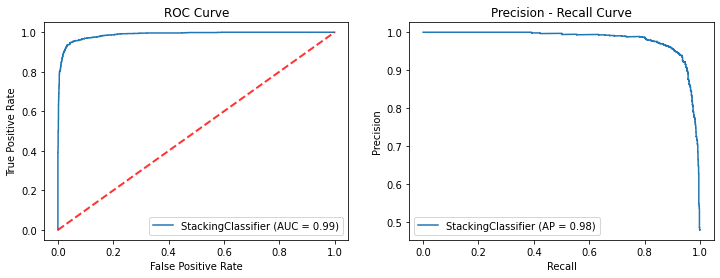

In [124]:
target_names = ['non-anvi-vax', 'anti-vax']
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_roc_curve(clf, X_test, y_test, ax=ax[0])
ax[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax[0].set_title('ROC Curve')
plot_precision_recall_curve(clf, X_test, y_test, ax=ax[1])
ax[1].set_title('Precision - Recall Curve')
plt.show()

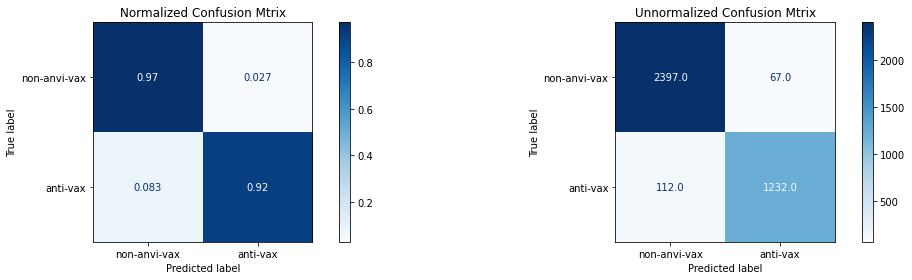

In [125]:
# print(classification_report(y_test, clf.predict(X_test), target_names=target_names))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
plot_confusion_matrix(clf, X_test, y_test, display_labels=target_names, normalize='true', cmap="Blues", ax=ax1)
ax1.set_title("Normalized Confusion Mtrix")
plot_confusion_matrix(clf, X_test, y_test, display_labels=target_names, cmap=plt.cm.Blues, values_format='.1f', ax=ax2)
ax2.set_title("Unnormalized Confusion Mtrix")
plt.tight_layout();

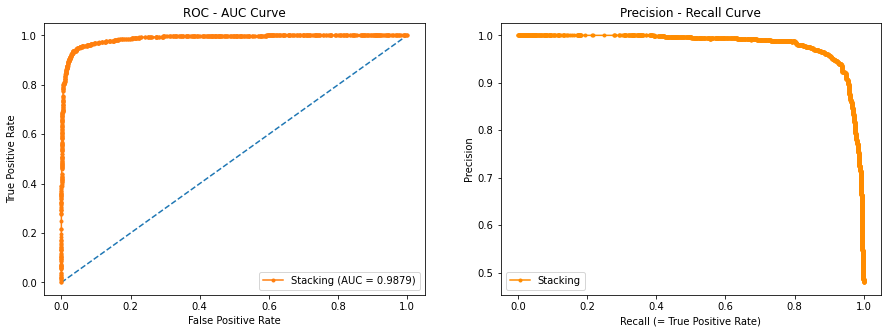

In [130]:
y_pred = clf.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
y_proba = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

yhat = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr2, tpr2, thresholds2 = roc_curve(y_test, yhat)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
## plot the roc curve for the model
ax1.plot([0,1], [0,1], linestyle='--')
ax1.plot(fpr2, tpr2, marker='.', label=f'Stacking (AUC = {round(auc,4)})')
# axis labels
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title("ROC - AUC Curve")
ax1.legend()
## plot the Precision-Recall curve for the model
ax2.plot(recall, precision, marker='.', label='Stacking', color="darkorange")
# axis labels
ax2.set_xlabel('Recall (= True Positive Rate)')
ax2.set_ylabel('Precision')
ax2.set_title("Precision - Recall Curve")
ax2.legend();

In [133]:
print("FPR:")
print(fpr2, "\n")
print('TPR:')
print(tpr2, "\n")
print('Precision:')
print(precision)
print("AUC score:")
print(auc)

FPR:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.0

Save our model:


In [ ]:
pickle_filename = 'stacking_updated.pickle'
pickle.dump(clf, open(pickle_filename, 'wb'))

### Let's see some examples:
(in order to do so we should scrape more data...)

In [132]:
y_pred_test = clf.predict(X_test)
test_hard_copy= X_test_hard_copy.merge(y_test.reset_index(), how='left', on='index')
text_miss = test_hard_copy.iloc[np.where(y_test!= y_pred_test)[0]][["text","category"]]
num= 0
for i,row in enumerate(text_miss.iterrows()):
  if num < 5:
    print(f"Tweet example number #{i+1}")
    if row[1]["category"] == 0:
      print("Non anti-Vaccine tweet that was missclassified as anti-vaccination tweet:")
    else:
      print("Anti-Vaccine tweet that was misclassified as non anti-vaccination tweet:")
    print(row[1]["text"])
    print("\n")
    num += 1

Tweet example number #1
Anti-Vaccine tweet that was misclassified as non anti-vaccination tweet:
@GuidoFawkes Implicit in those actions of course is their belief that a) #lockdown *is* an unwarranted over-reactio… https://t.co/tz09bOxuji


Tweet example number #2
Anti-Vaccine tweet that was misclassified as non anti-vaccination tweet:
#antivax 

Check out 🩸Mr Meetz 🪓's video! #TikTok https://t.co/SLtkdjaVJi


Tweet example number #3
Non anti-Vaccine tweet that was missclassified as anti-vaccination tweet:
@aka_anastazia @alexmichelle822 @jaketapper Sowing doubt is way easier than following the science. We lectured on t… https://t.co/0ypkYpy2aM


Tweet example number #4
Anti-Vaccine tweet that was misclassified as non anti-vaccination tweet:
RT @DritzyDraws: My mother had chicken pox as a kid due to not getting vaccinated, and now suffers from shingles and bone density issues ar…


Tweet example number #5
Non anti-Vaccine tweet that was missclassified as anti-vaccination tweet:
Thus far

Not much of a surprise after looking at the tweets content. After reading those tweets, evenI don't think that the 
"anti-vaccination tweets” are actually negative toward vaccination. some of them aren't even related to vaccination!
 
So all in all, I think that our model is working fantastic!